## Homework

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_file = '../data/airbnb_data.csv'
feature_set = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group', 'room_type', 'price']

df = pd.read_csv(data_file, usecols=feature_set)
df = df.fillna(0)
df['price'] = np.log1p(df['price'])
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1
Which feature is used for splitting the data?

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [5]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Answer: **room_type**

### Question 2
What's the RMSE of the random forest model (n_estimators=10, random_state=1, n_jobs=-1) on validation?

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [8]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.46156323035140573

### Question 3
After which value of n_estimators does RMSE stop improving?

In [9]:
rmses = []
for estimators in range(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmses.append((estimators, rmse))
    
df_rmses = pd.DataFrame(rmses, columns=["n_estimators", "rmse"])
df_rmses

,n_estimators,rmse
0,10,0.461563
1,20,0.448184
2,30,0.445535
3,40,0.443637
4,50,0.442325
5,60,0.441639
6,70,0.441218
7,80,0.441106
8,90,0.440533
9,100,0.439958


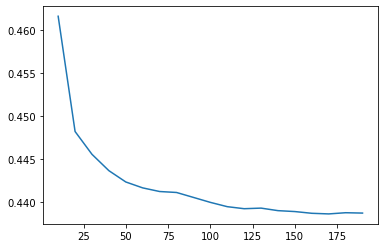

In [10]:
plt.plot(df_rmses.n_estimators, df_rmses.rmse)

Antwort: **120**

### Question 4
Let's select the best max_depth ([10, 15, 20, 25])

In [11]:
rmses = []
for depth in [10, 15, 20, 25]:
    for estimators in range(10, 200, 10):
        rf = RandomForestRegressor(max_depth=depth, n_estimators=estimators, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append((depth, estimators, rmse))
        
df_rmses = pd.DataFrame(rmses, columns=["depth", "n_estimators", "rmse"])
df_rmses

,depth,n_estimators,rmse
0,10,10,0.445553
1,10,20,0.442009
2,10,30,0.441381
3,10,40,0.441472
4,10,50,0.441067
...,...,...,...
71,25,150,0.438984
72,25,160,0.438769
73,25,170,0.438696
74,25,180,0.438848


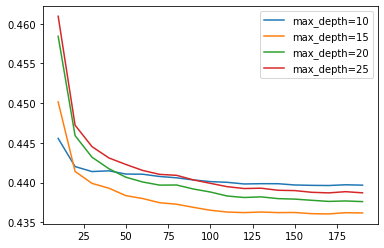

In [12]:
for depth in [10, 15, 20, 25]:
    df_subset = df_rmses[df_rmses.depth == depth]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % depth)
plt.legend()

Answer: **15**

Will the answer be different if we change the seed for the model?

Answer: **no**

### Question 5
What's the most important feature?

In [13]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
pd.DataFrame(dv.get_feature_names(), rf.feature_importances_)

,0
0.076264,availability_365
0.030102,calculated_host_listings_count
0.152775,latitude
0.154101,longitude
0.053252,minimum_nights
0.000265,neighbourhood_group=Bronx
0.000966,neighbourhood_group=Brooklyn
0.034047,neighbourhood_group=Manhattan
0.001166,neighbourhood_group=Queens
0.000084,neighbourhood_group=Staten Island


Antwort: **room_type=Entire home/apt**

## Question 6

In [14]:
import xgboost as xgb

In [ ]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
rmses = []
for eta in [0.3, 0.1, 0.01]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmses.append((eta, rmse))
    print("done", eta)
    
df_rmses = pd.DataFrame(rmses, columns=["eta", "rmse"])
df_rmses